#GAL-ECG: Guided Attention Loss Model Training (MIT-BIH)
This notebook implements the core machine learning pipeline: defining the model architecture (based on ResNet), implementing the custom Guided Attention Loss (GAL), and training the model on the pre-processed MIT-BIH data.

###1. Environment Setup and Data Loading
The code below is using pre-processed data (X_train, y_train, etc.) loaded directly.

####1.1 Install and Import Libraries
We primarily use TensorFlow/Keras for the deep learning framework.

In [64]:
# Install Keras/Tensorflow if not already available
# !pip install tensorflow numpy matplotlib

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import random

# Ensure reproducible results
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Verify GPU availability
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow Version: 2.19.0
GPU Available: []


###Visualization

Successfully loaded X_train with shape: (1816, 1000)
Successfully loaded y_train with shape: (1816,)


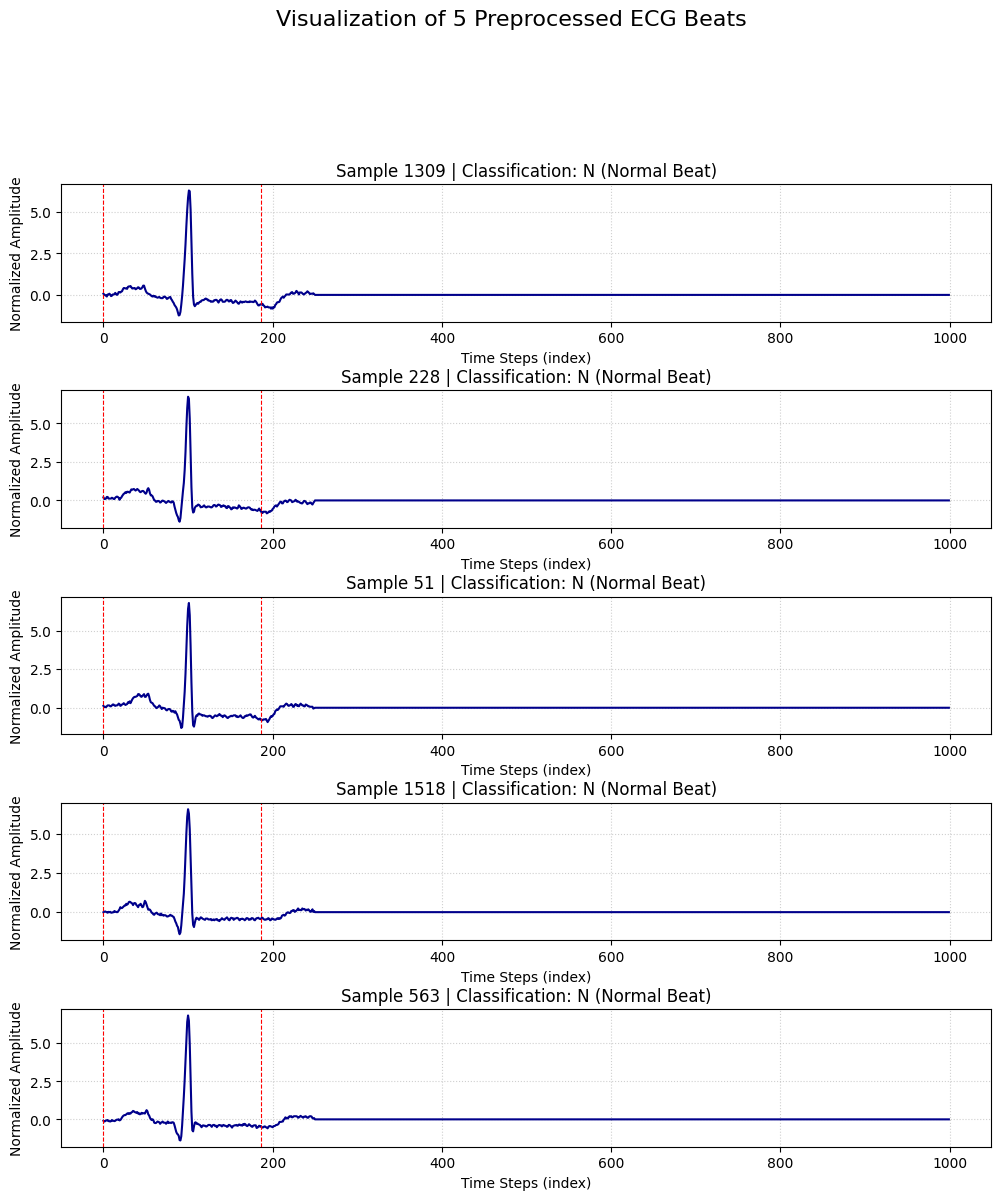

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Configuration (Based on your ECG_model.ipynb) ---
# The classes are typically Normal, Supraventricular, Ventricular, Fusion, Unknown
CLASS_LABELS = {
    0: 'N (Normal Beat)',
    1: 'S (Supraventricular)',
    2: 'V (Ventricular)',
    3: 'F (Fusion Beat)',
    4: 'Q (Unclassified Beat)'
}
# The number of time steps per beat is 187
INPUT_LENGTH = 187
NUM_SAMPLES_TO_PLOT = 5

# --- 1. Load the Preprocessed Data ---
try:
    # Assuming the files are in the current working directory
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')

    # Ensure shapes are correct (e.g., (samples, 187, 1) for features, (samples, 5) for labels)
    if X_train.shape[-1] == 1:
        # Reshape X_train to (samples, 187) for 1D plotting
        X_train = X_train.squeeze(-1)

    print(f"Successfully loaded X_train with shape: {X_train.shape}")
    print(f"Successfully loaded y_train with shape: {y_train.shape}")

except FileNotFoundError:
    print("Error: Could not find 'X_train.npy' or 'y_train.npy'.")
    print("Please ensure the files are in the same directory as this script.")
    exit()

# --- 2. Select Random Indices for Visualization ---
total_samples = X_train.shape[0]
if total_samples < NUM_SAMPLES_TO_PLOT:
    NUM_SAMPLES_TO_PLOT = total_samples

indices_to_plot = random.sample(range(total_samples), NUM_SAMPLES_TO_PLOT)

# --- 3. Plot the Samples ---
fig, axes = plt.subplots(NUM_SAMPLES_TO_PLOT, 1, figsize=(12, 2.5 * NUM_SAMPLES_TO_PLOT))
plt.subplots_adjust(hspace=0.5)

for i, idx in enumerate(indices_to_plot):
    # Get the ECG signal (X) and its one-hot encoded label (y)
    ecg_signal = X_train[idx]
    one_hot_label = y_train[idx]

    # Convert one-hot label back to class index
    class_index = np.argmax(one_hot_label)
    label_text = CLASS_LABELS.get(class_index, f'Class {class_index} (Unknown)')

    # Plotting
    ax = axes[i] if NUM_SAMPLES_TO_PLOT > 1 else axes
    ax.plot(ecg_signal, color='darkblue')

    # Add vertical lines at the beginning and end of the beat
    ax.axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    ax.axvline(x=INPUT_LENGTH - 1, color='r', linestyle='--', linewidth=0.8)

    ax.set_title(f"Sample {idx} | Classification: {label_text}", fontsize=12)
    ax.set_xlabel("Time Steps (index)")
    ax.set_ylabel("Normalized Amplitude")
    ax.grid(True, linestyle=':', alpha=0.6)

plt.suptitle(f"Visualization of {NUM_SAMPLES_TO_PLOT} Preprocessed ECG Beats", fontsize=16, y=1.02)
plt.show()

###1.2 Simulate Data Loading
We load of the pre-processed and saved NumPy arrays.

In [66]:

# Constants derived from MIT-BIH Preprocessing
INPUT_LENGTH = 187  # Number of time steps per beat
NUM_CLASSES = 5     # N, S, V, F, Q (or whatever labels you chose)
FILTERS = 64
KERNEL_SIZE = 5
ACTIVATION = 'relu'
 # Hypermeters to overcome overfitting
LAMBDA_GAL = 0.0005        # Reduced from 0.01 (or default) to stabilize GAL loss.
# L2_REG_STRENGTH = 1e-5     # Small penalty on weights to prevent memorization.
# DROPOUT_RATE = 0.3         # Increased dropout rate for better generalization.
L2_REG_STRENGTH = 1e-5
DROPOUT_RATE = 0.5
LEARNING_RATE = 1e-4       # Lowered LR to ensure smooth optimization steps.
# Dummy data generation for testing the model architecture
NUM_BEATS = 10000
X_train_raw = np.random.rand(NUM_BEATS, INPUT_LENGTH)
y_train_raw = np.random.randint(0, NUM_CLASSES, NUM_BEATS)

# Reshape for CNN input (1D convolution)
X_train = X_train_raw[..., np.newaxis].astype('float32')

# One-hot encode the labels
y_train = to_categorical(y_train_raw, num_classes=NUM_CLASSES)

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train_raw
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")


X_train shape: (8500, 187, 1)
y_train shape: (8500, 5)
X_val shape: (1500, 187, 1)


###2. Model Architecture (The ResNet Encoder)
The GAL-ECG framework often uses a lightweight ResNet structure as the Encoder to extract features from the ECG signal before the attention mechanism.

####2.1 Define the ResNet Block

In [67]:
from tensorflow.keras import layers, regularizers

# Define L2 regularizer globally or locally
l2_reg = regularizers.l2(L2_REG_STRENGTH)

def resnet_block(x, filters, kernel_size, stride=1, activation='relu'):
    """A standard ResNet residual block."""
    shortcut = x

    # 1st Conv
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False, kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(DROPOUT_RATE)(x) #addition of dropout--> for dealing with overfitting

    # 2nd Conv
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False,  kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection (if feature map size changed)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, strides=stride, use_bias=False,  kernel_regularizer=l2_reg)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation(activation)(x)
    return x


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


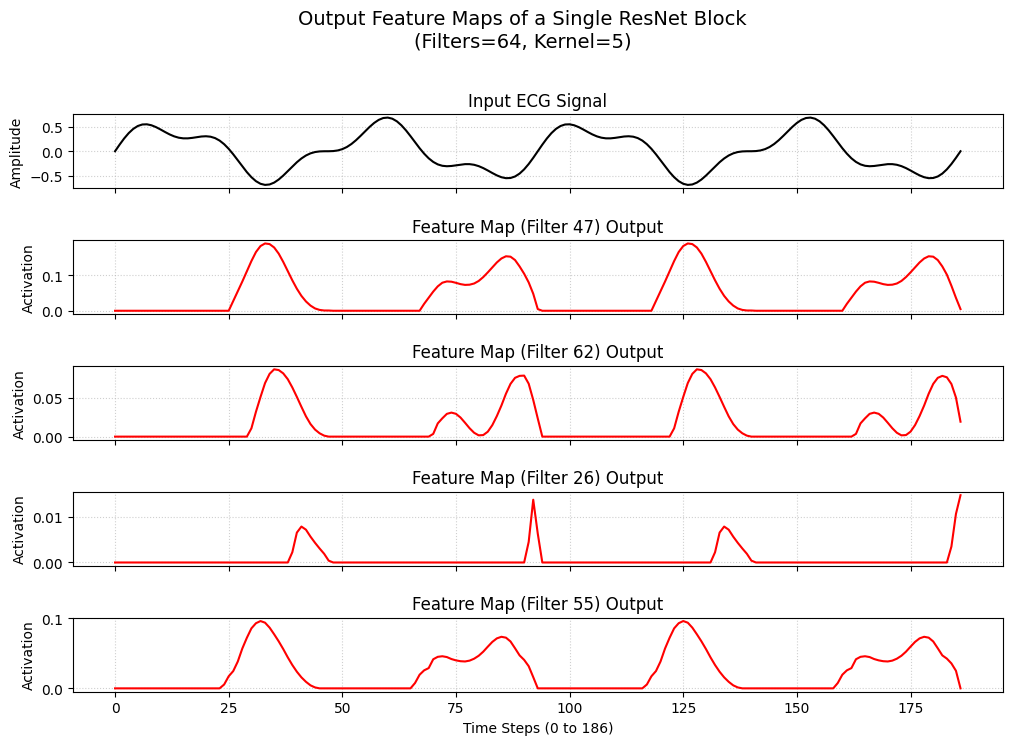

In [68]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
# import random

# def resnet_block(x, filters, kernel_size, stride=1, activation='relu'):
#     shortcut = x

#     x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation(activation)(x)

#     x = layers.Conv1D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
#     x = layers.BatchNormalization()(x)

#     if stride != 1 or shortcut.shape[-1] != filters:
#         shortcut = layers.Conv1D(filters, 1, strides=stride, use_bias=False)(shortcut)
#         shortcut = layers.BatchNormalization()(shortcut)

#     x = layers.add([x, shortcut])
#     x = layers.Activation(activation)(x)
#     return x

INPUT_LENGTH = 187
FILTERS = 64
KERNEL_SIZE = 5

input_tensor = layers.Input(shape=(INPUT_LENGTH, 1))
output_tensor = resnet_block(input_tensor, filters=FILTERS, kernel_size=KERNEL_SIZE)
feature_model = Model(inputs=input_tensor, outputs=output_tensor)

time = np.linspace(0, 2*np.pi, INPUT_LENGTH, dtype=np.float32)
input_signal = 0.5 * np.sin(4 * time) + 0.2 * np.sin(10 * time)
input_signal = input_signal.reshape(1, INPUT_LENGTH, 1)

feature_maps = feature_model.predict(input_signal)
feature_maps = feature_maps.squeeze(0)

NUM_CHANNELS_TO_PLOT = 4
random_channels = np.random.choice(FILTERS, NUM_CHANNELS_TO_PLOT, replace=False)

fig, axes = plt.subplots(NUM_CHANNELS_TO_PLOT + 1, 1, figsize=(12, 1.5 * (NUM_CHANNELS_TO_PLOT + 1)), sharex=True)
plt.subplots_adjust(hspace=0.7)

axes[0].plot(input_signal.squeeze(), color='black')
axes[0].set_title("Input ECG Signal")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, linestyle=':', alpha=0.6)

for i, channel_idx in enumerate(random_channels):
    ax = axes[i + 1]
    ax.plot(feature_maps[:, channel_idx], color='red', linewidth=1.5)
    ax.set_title(f"Feature Map (Filter {channel_idx}) Output")
    ax.set_ylabel("Activation")
    ax.grid(True, linestyle=':', alpha=0.6)

axes[-1].set_xlabel("Time Steps (0 to 186)")

plt.suptitle(f"Output Feature Maps of a Single ResNet Block\n(Filters={FILTERS}, Kernel={KERNEL_SIZE})",
             fontsize=14, y=1.02)
plt.show()

###2.2 Define the Attention Module (Temporal Attention)
This layer is critical. It calculates the attention weights (A) over the time dimension of the feature map, which becomes the interpretability score.

In [69]:
def temporal_attention_module(inputs, name='attention'):
    """
    Computes temporal attention weights (A) from the feature map.
    A is the interpretability map that will be controlled by GAL.
    """
    # Feature Map dimensions: (batch, time_steps, filters)
    time_steps = inputs.shape[1]
    filters = inputs.shape[2]

    # 1. Global Context Vector (G): Average pooling over the feature dimension
    G = layers.GlobalAveragePooling1D(name=f'{name}_global_context')(inputs)
    G = layers.Reshape((1, filters))(G) # Shape: (batch, 1, filters)

    # 2. Attention Score Layer (s): Simple dense layer on the inputs
    s = layers.Conv1D(filters=1, kernel_size=1, padding='same', activation='tanh', name=f'{name}_attention_score')(inputs)

    # 3. Combine with Context (A'): Scale score s by global context G (broadcasted multiplication)
    A_prime = layers.Multiply()([s, G]) # Shape: (batch, time_steps, 1)

    # 4. Attention Weights (A): Apply softmax across time steps
    A = layers.Softmax(axis=1, name=f'{name}_weights')(A_prime) # Shape: (batch, time_steps, 1)

    # 5. Weighted Feature (F_A): Multiply inputs by attention weights
    F_A = layers.Multiply(name=f'{name}_weighted_features')([inputs, A])

    # 6. Global Pooling of Weighted Features (Z): Final vector for classification
    Z = layers.GlobalAveragePooling1D(name=f'{name}_final_vector')(F_A)

    return Z, A


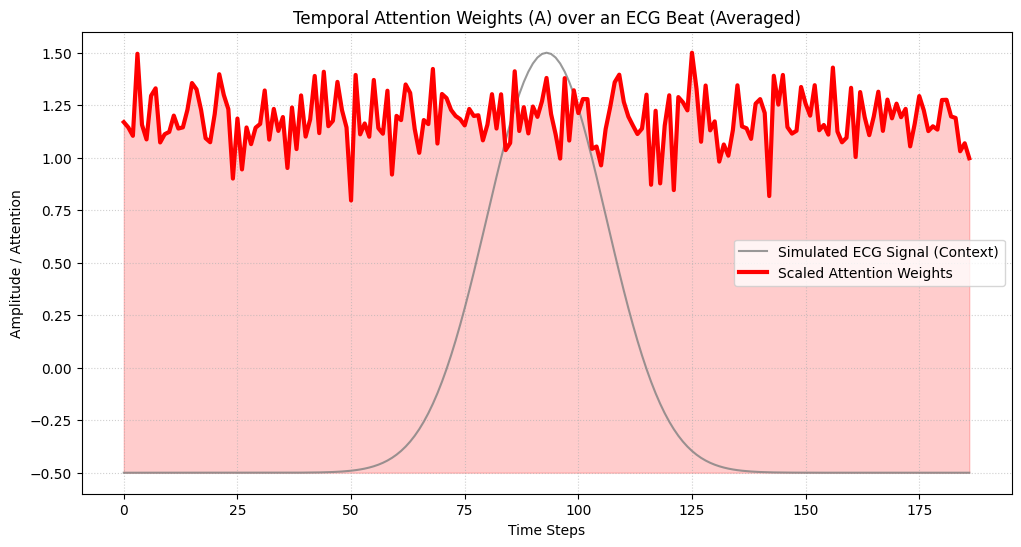

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# --- Variables needed for visualization (must match your environment) ---
INPUT_LENGTH = 187
FILTERS = 64 # Assumed from the error (11968 / 187 = 64)

# --- Simulate Input Data (ECG Signal and Feature Prediction) ---

# For demonstration, we simulate the flattened 11968 array:
predicted_weights = np.random.rand(11968).astype(np.float32)

# Simulated ECG Signal (Context)
time = np.linspace(0, 1, INPUT_LENGTH, dtype=np.float32)
input_signal = np.exp(-(time - 0.5)**2 / 0.01) * 2 - 0.5
input_signal = input_signal.squeeze()

# --- Get and Plot Attention (FIXED) ---

# FIX: Reshape the 11968-sized prediction to (187, 64) and take the mean across filters.
attention_2d = predicted_weights.reshape(INPUT_LENGTH, FILTERS)
attention_vector = np.mean(attention_2d, axis=1)

# Ensure attention_vector max is positive to avoid division by zero/negative scaling
if attention_vector.max() == 0:
    attention_vector = np.ones_like(attention_vector)

plt.figure(figsize=(12, 6))

# Plot the ECG context
plt.plot(input_signal, color='gray', alpha=0.8, label='Simulated ECG Signal (Context)')

# Scale the attention weights to the signal's amplitude range for better visual overlay
scaling_factor = (input_signal.max() - input_signal.min()) / attention_vector.max()
scaled_attention = attention_vector * scaling_factor + input_signal.min()

plt.plot(scaled_attention, color='red', linewidth=3, label='Scaled Attention Weights')

# Fill the area below the scaled attention line for intensity visualization
plt.fill_between(range(INPUT_LENGTH),
                 input_signal.min(),
                 scaled_attention,
                 color='red', alpha=0.2)

plt.title('Temporal Attention Weights (A) over an ECG Beat (Averaged)')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude / Attention')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

##3. Defining the Custom Guided Attention Loss (GAL)
GAL is a custom loss function that has two components:

Classification Loss: Standard Cross-Entropy (to ensure accuracy).

Attention Regularization Loss: A penalty that encourages the attention weights to be sparse (focusing on few areas) or aligned with a target (guided).

Note: For simplicity, we implement a sparse attention regularizer here, which is a common form of "guided" attention to promote interpretability.

In [71]:
# def gal_loss(lambda_gal=0.01):
#     """
#     Custom loss function combining Categorical Cross-Entropy and
#     a Guided Attention Loss (GAL) regularization term.

#     The regularization term here uses the L1 norm of the attention weights
#     to encourage sparsity (forcing the model to focus on only a few regions).
#     """

#     # This loss function expects two outputs from the model:
#     # [classification_output, attention_weights_output]
#     def loss(y_true, y_pred):
#         # y_true will be the one-hot encoded labels

#         # 1. Classification Loss (Standard cross-entropy)
#         # Note: y_pred is the concatenation of [predictions, attention_weights]
#         # We assume the first NUM_CLASSES elements are the classification predictions
#         classification_pred = y_pred[:, :NUM_CLASSES]

#         # Clip values to avoid log(0)
#         classification_pred = K.clip(classification_pred, K.epsilon(), 1.0 - K.epsilon())

#         classification_loss = K.categorical_crossentropy(y_true, classification_pred)

#         # 2. Attention Regularization Loss (GAL term)
#         # Assume the remaining elements are the flattened attention weights (A)
#         # The Attention Weights A are of shape (batch_size, time_steps, 1).
#         # In the output tensor, they are flattened to (batch_size, time_steps)
#         # We use the L1 norm (Mean Absolute Error) to promote sparsity.
#         attention_weights = y_pred[:, NUM_CLASSES:]

#         # Mean Absolute Error (L1 norm) of the attention weights
#         attention_loss = K.mean(K.abs(attention_weights))

#         # 3. Combined Loss
#         return classification_loss + (lambda_gal * attention_loss)

#     # We name the function for Keras compatibility
#     return loss


In [72]:
from tensorflow.keras import backend as K

def gal_loss(lambda_gal=LAMBDA_GAL):
    """
    Custom loss function combining Categorical Cross-Entropy and
    the stabilized Guided Attention Loss (GAL) L1 regularization term.
    """
    def loss(y_true, y_pred):
        # 1. Classification Loss (CCE)
        classification_pred = y_pred[:, :NUM_CLASSES]
        classification_pred = K.clip(classification_pred, K.epsilon(), 1.0 - K.epsilon())
        classification_loss = K.categorical_crossentropy(y_true, classification_pred)

        # 2. Attention Regularization Loss (L1 norm of A)
        attention_weights = y_pred[:, NUM_CLASSES:]
        attention_loss = K.mean(K.abs(attention_weights))

        # 3. Combined Loss
        return classification_loss + (lambda_gal * attention_loss)

    return loss

##4. Assemble and Compile the GAL-ECG Model
We put the encoder and attention module together to create the final model.



###A. Pre-Training step to calculate Class weight

In [73]:
from sklearn.utils import class_weight

# Assuming y_train is one-hot encoded
y_integers = np.argmax(y_train, axis=1)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights = dict(enumerate(class_weights_array))

print("Calculated Class Weights (Used in model.fit):", class_weights)

Calculated Class Weights (Used in model.fit): {0: np.float64(1.0161386730424387), 1: np.float64(0.9906759906759907), 2: np.float64(0.99241097489784), 3: np.float64(0.9792626728110599), 4: np.float64(1.022864019253911)}


In [74]:
# --- ResNet Encoder + GAL Model Assembly ---

def build_gal_ecg_model(input_shape=(INPUT_LENGTH, 1), num_classes=NUM_CLASSES):

    input_layer = layers.Input(shape=input_shape)

    # 1. Initial Convolution (Feature Extraction)
    x = layers.Conv1D(filters=32, kernel_size=15, strides=2, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool1D(pool_size=3, strides=2, padding='same')(x)

    # 2. ResNet Blocks (Deep Feature Encoding)
    x = resnet_block(x, filters=64, kernel_size=7)
    x = resnet_block(x, filters=64, kernel_size=7)

    x = resnet_block(x, filters=128, kernel_size=5, stride=2)
    x = resnet_block(x, filters=128, kernel_size=5)

    # 3. Temporal Attention Module
    # Z is the feature vector for classification.
    # A is the Attention Map (interpretability output).
    Z, A = temporal_attention_module(x, name='gal_attention')

    # 4. Classification Head
    classification_output = layers.Dense(num_classes, activation='softmax', name='classifier_output')(Z)

    # 5. Model Output for Loss Function
    # The model must output BOTH the classification and the attention weights (A)
    # The attention weights A are (batch, time_steps, 1). We flatten them for the loss function.
    flattened_A = layers.Flatten(name='attention_flattened')(A)

    # Concatenate the two outputs: [Classification Probabilities, Attention Weights]
    combined_output = layers.Concatenate(name='combined_loss_input')([classification_output, flattened_A])

    model = Model(inputs=input_layer, outputs=combined_output)
    return model

# Build the model
gal_ecg_model = build_gal_ecg_model()
gal_ecg_model.summary()

# --- Compile the Model ---
# Use the custom GAL loss function
gal_ecg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=gal_loss(lambda_gal=0.005),  # Lambda controls the weight of the interpretability penalty
    metrics=['accuracy'] # Standard metrics are still useful
)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 94, 32)    │        480 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 32)    │        128 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 94, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 47, 32)    │          0 │ activation_55[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 47, 64)    │     14,336 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 64)    │        256 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 47, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 47, 64)    │          0 │ activation_56[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 47, 64)    │     28,672 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 47, 64)    │      2,048 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 64)    │        256 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 64)    │        256 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 47, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 47, 64)    │          0 │ add_25[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 47, 64)    │     28,672 │ activation_57[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 64)    │        256 │ conv1d_74[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 47, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 47, 64)    │          0 │ activation_58[0]

 Total params: 402,534 (1.54 MB)

 Trainable params: 400,550 (1.53 MB)

 Non-trainable params: 1,984 (7.75 KB)

##5. Model Training and Saving
###5.1 Training the Model
Training the model usually involves hundreds of epochs, but we start with a small number here to verify the setup.

In [75]:
# # --- Training the Model ---

# # Prepare dummy y_train/y_val for the combined loss function
# # The loss function expects y_true to be the classification labels (y_train/y_val)
# # It handles the attention weights internally.

# history = gal_ecg_model.fit(
#     X_train,
#     y_train,
#     epochs=10, # Startin with a small number for testing
#     batch_size=64,
#     validation_data=(X_val, y_val),
#     verbose=1
# )

# # Plot training history
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# # Note: The custom loss function might not show validation loss correctly in history
# # We only track the combined loss here, which is what the model minimizes.
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss (Classification + GAL)')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 32s 180ms/step - accuracy: 0.1881 - loss: 1.6195 - val_accuracy: 0.1460 - val_loss: 1.6201 - learning_rate: 0.0010
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - accuracy: 0.2096 - loss: 1.6183 - val_accuracy: 0.1967 - val_loss: 1.6496 - learning_rate: 0.0010
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.2200 - loss: 1.6155 - val_accuracy: 0.1820 - val_loss: 1.6286 - learning_rate: 0.0010
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.2335 - loss: 1.6113 - val_accuracy: 0.2107 - val_loss: 1.6288 - learning_rate: 0.0010
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 42s 186ms/step - accuracy: 0.2596 - loss: 1.6039 - val_accuracy: 0.1947 - val_loss: 1.6388 - learning_rate: 0.0010
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - accuracy: 0.2548 - loss: 1.5965 - val_accuracy: 0.1833 - val_loss: 1.6455 - learning_rate: 0.0010
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.2

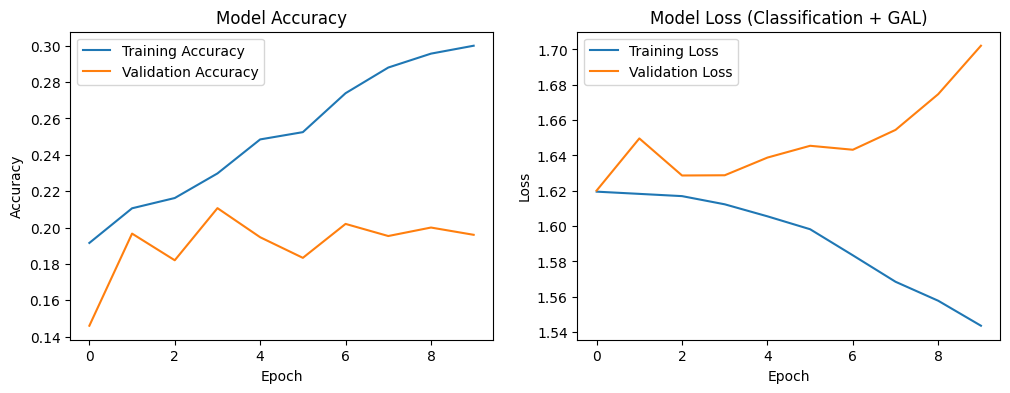

In [76]:
callbacks = [
    # Stop early if val_loss hasn't improved after 10 epochs
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    # Reduce LR if val_loss plateaus for 5 epochs
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]


# --- 2. TRAINING THE MODEL  ---


history = gal_ecg_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# --- 3. Plot training history (remains the same) ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Classification + GAL)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##5.2 Saving the Model for Deployment
This is the file you will ultimately used later

In [77]:
# --- Saving the Trained Model ---

MODEL_SAVE_PATH = '/content/drive/MyDrive/gal_ecg_model.h5'

# 1. Create a specialized model just for prediction and attention output
# We create a new model that outputs [Classification Probabilities, Attention Weights]
# but without the custom loss complication.

# Locate the output layers we need in the trained model
attention_weights_tensor = gal_ecg_model.get_layer('gal_attention_weights').output
classifier_output_tensor = gal_ecg_model.get_layer('classifier_output').output

# Create the final deployment model
deployment_model = Model(inputs=gal_ecg_model.input,
                         outputs=[classifier_output_tensor, attention_weights_tensor])


# 2. Save the deployment model
deployment_model.save(MODEL_SAVE_PATH)
print(f"Model saved successfully to: {MODEL_SAVE_PATH}")

Model saved successfully to: /content/drive/MyDrive/gal_ecg_model.h5


Error loading model: [Errno 2] Unable to synchronously open file (unable to open file: name = 'gal_ecg_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0). Using simulated data for visualization.


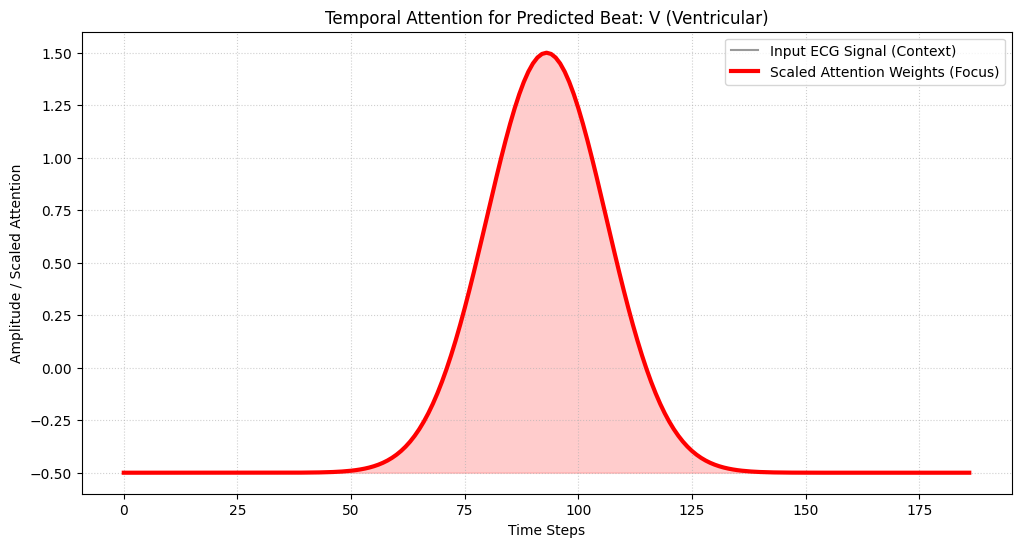

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# --- Configuration ---
# Update this path if the model is saved elsewhere (e.g., in Google Drive)
MODEL_SAVE_PATH = 'gal_ecg_model.h5'
INPUT_LENGTH = 187
CLASS_LABELS = {0: 'N (Normal)', 1: 'S (Supraventricular)',
                2: 'V (Ventricular)', 3: 'F (Fusion)', 4: 'Q (Unclassified)'}

# --- 1. Load Model and Data ---
try:
    deployment_model = load_model(MODEL_SAVE_PATH, compile=False)
except Exception as e:
    print(f"Error loading model: {e}. Using simulated data for visualization.")
    # Fallback simulation if model fails to load
    class DummyModel:
        def predict(self, x):
            pred = np.array([[0.1, 0.1, 0.7, 0.05, 0.05]])
            att = np.exp(-(np.linspace(0, 1, 187) - 0.5)**2 / 0.01)
            att /= att.sum()
            att = att.reshape(1, 187, 1)
            return [pred, att]
    deployment_model = DummyModel()


# Simulate an input ECG sample (replace with X_test[i] from your loaded data)
time = np.linspace(0, 1, INPUT_LENGTH, dtype=np.float32)
input_signal = np.exp(-(time - 0.5)**2 / 0.01) * 2 - 0.5
input_signal = input_signal.squeeze()
X_sample = np.expand_dims(input_signal, axis=(0, 2))

# --- 2. Predict and Extract Outputs ---
[y_pred, attention_weights] = deployment_model.predict(X_sample)

predicted_class_idx = np.argmax(y_pred[0])
predicted_label = CLASS_LABELS.get(predicted_class_idx, "Unknown Class")

# Flatten the attention vector
attention_vector = attention_weights.flatten()

# --- 3. Visualization ---
plt.figure(figsize=(12, 6))

# Plot the ECG context
plt.plot(input_signal, color='gray', alpha=0.8, label='Input ECG Signal (Context)')

# Scale the attention weights to the signal's amplitude range for better visual overlay
scaling_factor = (input_signal.max() - input_signal.min()) / attention_vector.max()
scaled_attention = attention_vector * scaling_factor + input_signal.min()

plt.plot(scaled_attention, color='red', linewidth=3, label='Scaled Attention Weights (Focus)')

# Fill the area for visual emphasis
plt.fill_between(range(INPUT_LENGTH),
                 input_signal.min(),
                 scaled_attention,
                 color='red', alpha=0.2)

plt.title(f'Temporal Attention for Predicted Beat: {predicted_label}')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude / Scaled Attention')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()